In [1]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from dateutil.parser import parse

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [21]:
print(tf.__version__)

print(tf.keras.__version__)

print(pd.__version__)

2.2.0-rc3
2.3.0-tf
1.0.3


In [167]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/result.csv', encoding='cp949').set_index('date')
# print(data.shape)
data.head(2)

,stock_Asia,stock_Jobi,stock_Hyosung,stock_Farming,stock_Namhae_Chemical,stock_KGChemical,stock_Nongwoo_Bio,stock_Sungbo_Chemical,stock_Asia_Tech,stock_Eastern_Agro,stock_KPX,potato_price,tomato,green_pepper,red_pepper,cabbage,cabbage1,onion,carrot,green_onion,cucumber,Exchange_Rate,KOSPI,Dubai,Brent,WTI,시장금리
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-08-01,3300.0,12000.0,17300.0,5780.0,9260.0,13700.0,20650.0,42350.0,3455.0,6380.0,3020.0,18593.0,8158.0,24381.0,28722.0,5388.0,5534.0,593.0,39369.0,1156.0,62722.0,1037.75,2073.10,677.23,676.71,631.78,2.48
2014-08-04,3300.0,12000.0,17350.0,5900.0,9280.0,13700.0,21100.0,43050.0,3465.0,6370.0,3050.0,20535.0,7925.0,32983.0,41805.0,9059.0,4286.0,600.0,41218.0,1510.0,43128.0,1033.35,2080.42,670.67,685.36,639.07,2.48


In [0]:
# dt_index = pd.DataFrame(pd.date_range(start=data.iloc[0,0], end=str(parse(data.iloc[-1,0]) + timedelta(days=1)), freq = 'B')).rename(columns = {0 : 'date'})
# dt_index['date'] = dt_index['date'].astype(str)

# main_data = pd.merge(dt_index, data, how = 'left', on = 'date').set_index('date')

# main_data.tail(2)

In [223]:
target_names = ['stock_Jobi','onion','carrot']
#df = data[]
shift_steps = 1

df = data[target_names]# .iloc[:-1,:]

df.tail(3)

,stock_Jobi,onion,carrot
date,,,
2019-12-27,15150.0,820.0,38621.0
2019-12-30,15300.0,817.0,42100.0
2019-12-31,15300.0,809.0,38990.0


In [224]:
df_targets = df['stock_Jobi'].shift(-shift_steps)
# df_targets = df.shift(-shift_steps)

df_targets.tail(3)

date
2019-12-27    15300.0
2019-12-30    15300.0
2019-12-31        NaN
Name: stock_Jobi, dtype: float64

In [225]:
x_data = df.values[0:-shift_steps]

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1435, 3)


In [226]:
y_data = df_targets.values[:-shift_steps].reshape(-1,1)

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1435, 1)


In [227]:
num_data = len(x_data)
num_data

1435

In [228]:
train_split = 0.9

num_train = int(train_split * num_data)
num_train

1291

In [229]:
num_test = num_data - num_train
num_test

144

In [230]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

1435
1435


In [231]:
# input 갯수
num_x_signals = x_data.shape[1]
num_x_signals

3

In [232]:
# output 갯수
num_y_signals = y_data.shape[1]
num_y_signals

1

In [233]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 390.0
Max: 76280.0


In [234]:
# Scaled Data
x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [0]:
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [236]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(1291, 3)
(1291, 1)


In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 128

In [239]:
sequence_length = 365
sequence_length

365

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [242]:
print(x_batch.shape)
print(y_batch.shape)

(128, 365, 3)
(128, 365, 1)


In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

model.add(Dense(num_y_signals, activation='sigmoid'))

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [0]:
warmup_steps = 100

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [247]:
optimizer = RMSprop(lr=1e-3)

model.compile(loss=loss_mse_warmup, optimizer=optimizer)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 512)         794112    
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           513       
Total params: 794,625
Trainable params: 794,625
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [253]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0118
Epoch 00001: val_loss improved from inf to 0.00321, saving model to 23_checkpoint.keras
100/100 [==============================] - 34s 341ms/step - loss: 0.0118 - val_loss: 0.0032 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00002: val_loss improved from 0.00321 to 0.00055, saving model to 23_checkpoint.keras
100/100 [==============================] - 34s 338ms/step - loss: 0.0025 - val_loss: 5.4567e-04 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00003: val_loss did not improve from 0.00055

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 34s 338ms/step - loss: 0.0017 - val_loss: 8.4518e-04 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00004: val_loss improved from 0.00055 to 0.00026, 

In [0]:
# result_lst = []

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [256]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

print("loss (test-set):", result)

result_lst.append([str([str(i) for i in df.columns]), (round(result,5))])
print(result_lst)

1/1 [==============================] - 0s 2ms/step - loss: 2.5788e-04
loss (test-set): 0.00025787673075683415
[["['stock_Jobi']", 0.00026], ["['stock_Jobi', 'onion']", 0.00032], ["['stock_Jobi', 'onion', 'carrot']", 0.00026]]


In [257]:
pd.DataFrame(result_lst, columns = ['name', 'error']).sort_values(by = 'error')

,name,error
0,['stock_Jobi'],0.00026
2,"['stock_Jobi', 'onion', 'carrot']",0.00026
1,"['stock_Jobi', 'onion']",0.00032


In [258]:
len(y_test)

144

In [259]:
len(x_test)

144

In [0]:
# model.predict(np.expand_dims(x_test_scaled, axis=0))

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    signal = 0
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:, signal]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true[:, signal]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(target_names[signal])
    # plt.xlabel(np.array(dt_index.date))
    
    plt.legend()
    plt.show()

    # return signal_true, signal_pred

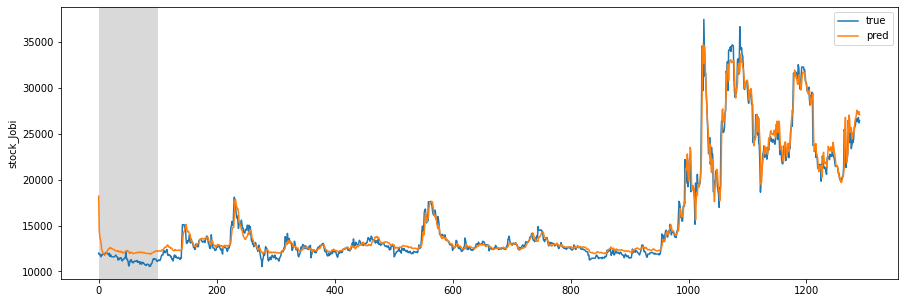

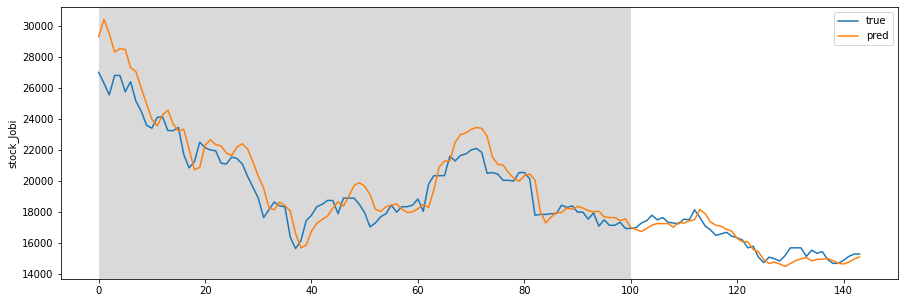

In [262]:
# stock_jobi & onion & carrot을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)

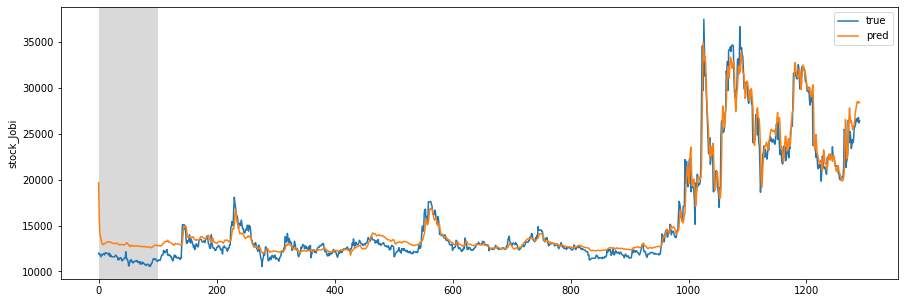

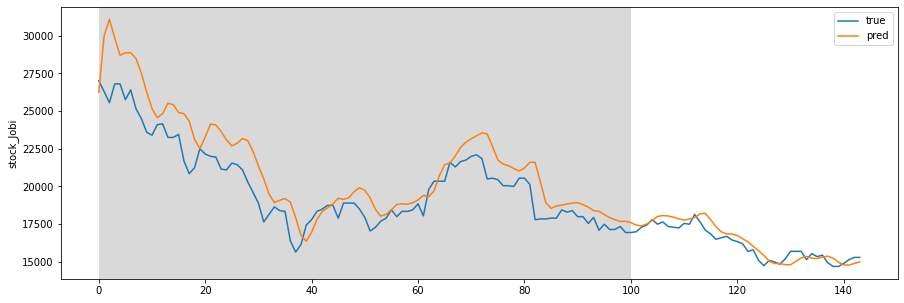

In [222]:
# stock_jobi & onion을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)

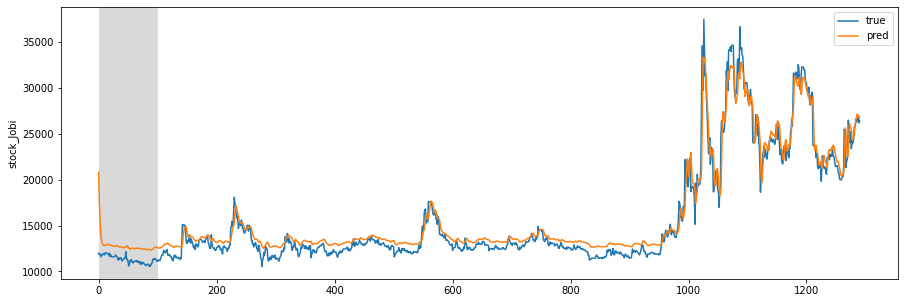

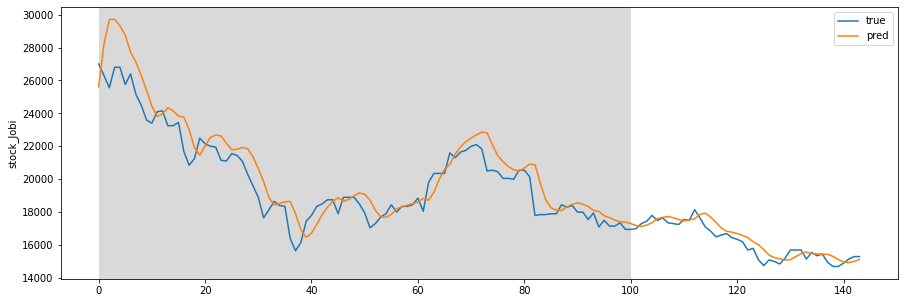

In [159]:
# stock_jobi을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)